<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Language-model" data-toc-modified-id="Language-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Language model</a></span></li><li><span><a href="#Classifier-model" data-toc-modified-id="Classifier-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Classifier model</a></span></li></ul></div>

### Load the data

In [0]:
import sqlite3
import pandas as pd
from fastai import*
from fastai.vision import*
from fastai.core import*
from fastai.metrics import accuracy
from sklearn.model_selection import train_test_split
from fastai.text import *

In [0]:
cd /

/


In [0]:
con = sqlite3.connect("pubmed_ids.db")
with con:
    df_ids = pd.read_sql_query("SELECT * from ids", con)
df_ids.head(20)

,id,class1,class2,class3
0,7,1.0,NaN,NaN
1,101,NaN,NaN,1.0
2,111,1.0,NaN,NaN
3,127,1.0,NaN,NaN
4,178,NaN,NaN,1.0
5,300,1.0,NaN,NaN
6,313,NaN,NaN,1.0
7,338,1.0,NaN,NaN
8,438,NaN,NaN,1.0
9,518,NaN,NaN,1.0


In [0]:
con = sqlite3.connect("pubmed_abstracts.db")
with con:
    df = pd.read_sql_query("SELECT * from abstracts", con)
df.tail(20)

,id,data
32895,31538461,<abstract>\n<abstracttext>Nonsyndromic cleft l...
32896,31593207,<abstract>\n<abstracttext>Alcohol-induced live...
32897,31593705,<abstract>\n<abstracttext>Taxifolin (TAX) repo...
32898,31595778,"<abstract>\n<abstracttext label=""OBJECTIVE"" nl..."
32899,31596835,
32900,31602838,<abstract>\n<abstracttext>The aim of this pape...
32901,31602840,<abstract>\n<abstracttext>The study aimed to i...
32902,31602841,<abstract>\n<abstracttext>To study the effects...
32903,31602911,<abstract>\n<abstracttext>Tripterygium wilford...
32904,31602916,<abstract>\n<abstracttext>The aim of this pape...


In [0]:
df_abstracts = pd.merge(df_ids, df, on='id')

In [0]:
df_abstracts.fillna(0, inplace=True)

In [0]:
df_abstracts['label'] = df_abstracts.apply(lambda row: (row.class1, row.class2, row.class3), axis=1)

In [0]:
df_abstracts_non_empty = df_abstracts[df_abstracts.data != '']
df_abstracts_non_empty['label'].value_counts()

(1.0, 1.0, 0.0)    6700
(0.0, 0.0, 1.0)    6307
(1.0, 0.0, 0.0)    5330
(1.0, 0.0, 1.0)    1083
(1.0, 1.0, 1.0)     294
Name: label, dtype: int64

In [0]:
abstracts = df_abstracts_non_empty.copy()

In [0]:
abstracts.data = abstracts.data.str.replace('<abstract>\n<abstracttext>', '')
abstracts.data = abstracts.data.str.replace('</abstracttext>\n</abstract>', '')

In [0]:
# data
abstracts.head()

,id,class1,class2,class3,data,label
7,338,1.0,0.0,0.0,This paper described a Behavior Modification T...,"(1.0, 0.0, 0.0)"
12,545,1.0,0.0,1.0,Current research on the effects on offspring o...,"(1.0, 0.0, 1.0)"
15,549,1.0,0.0,0.0,Substantial and prolonged withdrawal hyperexci...,"(1.0, 0.0, 0.0)"
20,633,1.0,1.0,0.0,The renal papilla has a double blood supply - ...,"(1.0, 1.0, 0.0)"
21,657,1.0,1.0,0.0,The authors report 5 cases of shock type anaph...,"(1.0, 1.0, 0.0)"


A multi-label classification has multiple target values associated with dataset. Here we are predicting probability of each class instead of predicting a single class. For this problem, we have 3 label classes: class1 - other abstracts, class2 - drug_side_effects abstracts, class3 - congenital_abnormalities abstracts. We have to create a model which predicts a probability of each class for each abstract. 

### Language model

In [0]:
# create databunch
data_lm = (TextList.from_df(abstracts, cols='data')
                .split_by_rand_pct(0.2, 42)
                .label_for_lm()  
                .databunch(bs=48))
data_lm.show_batch()

idx,text
0,". xxmaj research interest declined during xxmaj prohibition , and authorities later discounted the previous work . xxmaj recently a relationship between maternal drinking and abnormal morphogenesis has been again described . xxbos xxmaj substantial and prolonged withdrawal hyperexcitability in the neural substrate for affective defense was revealed by behavioral and electrophysiological measures in cats exposed to moderate to heavy doses of alcohol for periods ranging from 6 to 72"
1,"thus this is the third such recorded case . xxmaj allopurinol should be suspected when liver abnormalities occur following use of this drug . xxbos xxmaj in a retrospective study of 445 patients with nasal polyps , 95 ( 21 per cent ) had asthma . xxmaj forty - two ( 44 per cent ) of the patients with asthma had been skin tested and 27 ( 60 per cent"
2,"of the xxunk xxup tee , xxup xxunk permits the following additional images of the heart : 1 ) xxmaj longitudinal "" two - chamber - view "" for assessment of left ventricular ( xxup lv ) anterior , apical , and posterior wall motion , and for assessment of mitral valve anatomy and function ( e.g. , grading of color flow regurgitation ) . 2 ) xxmaj imaging of"
3,"a six - factor orthogonal solution was selected . xxmaj multiple regression analyses supported the established relationships of demographic variables , such as age and sex , with the tardive dyskinesia scores generated by the instrument . xxbos xxmaj the preliminary data on efficacy and safety of oral tocainide in refractory ventricular dysrhythmia in 8 patients is described . xxmaj two patients died ; one within 15 days and the"
4,normal . xxmaj the phenotypes of those with x deletions detectable by flow cytometry were similar to those of patients without such deletions . xxbos xxmaj the autosomal dominant form of polycystic kidney disease ( xxup adpkd ) has been linked to the alpha - globin gene locus on 16p . xxmaj linkage studies between the autosomal recessive type ( xxup arpkd ) and the 3 ' xxup xxunk of


In [0]:
# create learner
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
# find learning rate
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


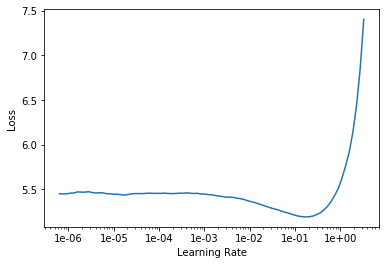

In [0]:
learn.recorder.plot()

In [0]:
#fit the model to our data
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.854535,3.586573,0.372885,05:10


In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.409118,3.442203,0.388160,06:04
1,3.307297,3.363883,0.396853,06:02
2,3.228161,3.315794,0.401890,06:02
3,3.084427,3.286897,0.404880,06:02
4,2.925977,3.281210,0.406453,06:03
5,2.756144,3.293452,0.407129,06:02
6,2.604333,3.317221,0.405581,06:03
7,2.417707,3.352296,0.403450,06:03
8,2.329478,3.377358,0.402361,06:02
9,2.264380,3.391056,0.401629,06:03


In [0]:
learn.save('lm_learner_tuned')

In [0]:
# save the encoder for use in classification
learn.save_encoder('lm_learner_tuned_enc')

### Classifier model

In [0]:
#label list
label_cols = ['class1', 'class2', 'class3']

data_clas = (TextList.from_df(abstracts, cols='data', vocab=data_lm.vocab)
             .split_by_rand_pct(0.2, 42)
             .label_from_df(cols=label_cols , classes=label_cols)
             .databunch(bs=48))

data_clas.show_batch()

text,target
"xxbos < abstract > \n < abstracttext label=""background"">medication - related adverse events in primary care represent an important cause of hospital admissions and mortality . xxmaj adverse events could result from people experiencing adverse drug reactions ( not usually preventable ) or could be due to medication errors ( usually preventable ) . < / abstracttext > \n < abstracttext label=""objectives"">to determine the effectiveness of professional , organisational",class1;class2
"xxbos < abstract > \n < abstracttext label=""study xxup design "" nlmcategory=""methods"">a prospective comparative analysis of surgically - treated xxunk primary pyogenic infection of the spine ( xxup ppis ) . < / abstracttext > \n < abstracttext label=""objective "" nlmcategory=""objective"">to evaluate and compare the demographics , presentation , treatment and outcomes of surgically - treated xxup ppis between intravenous drug users ( xxup ivdu ) and non",class1
"xxbos < abstract > \n < abstracttext label=""context "" nlmcategory=""background"">paracetamol ( acetaminophen ) poisoning is the most common cause of acute liver failure in the developed world . a paracetamol treatment nomogram has been used for over four decades to help determine whether patients will develop hepatotoxicity without acetylcysteine treatment , and thus indicates those needing treatment . xxmaj despite this , a small proportion of patients still develop",class1;class2
"xxbos xxmaj several lines of evidence imply alterations in adenosine signaling in xxmaj parkinson 's disease ( xxup pd ) . xxmaj here , we investigated cerebral changes in adenosine xxup 2a receptor ( a < sub>2a < / sub > r ) availability in 6-hydroxydopamine ( 6-ohda)-lesioned rats with and without levodopa - induced dyskinesia ( xxup lid ) using positron - emission tomography ( xxup pet ) with",class1;class2
"xxbos < abstract > \n < abstracttext label=""background "" xxunk medical record ( xxup emr ) screening for indicators of medication risk could improve efficiency in identifying primary care clinic patients in need of clinical pharmacist care compared with patient self - reporting . < / abstracttext > \n < abstracttext label=""objectives "" nlmcategory=""objective"">to ( a ) compare the performance of an xxup emr medication risk assessment questionnaire",class1;class2


In [0]:
# metrics
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [0]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[acc_02, f_score])

In [0]:
learn_classifier.load_encoder('lm_learner_tuned_enc')

In [0]:
learn_classifier.freeze()

In [0]:
learn_classifier.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


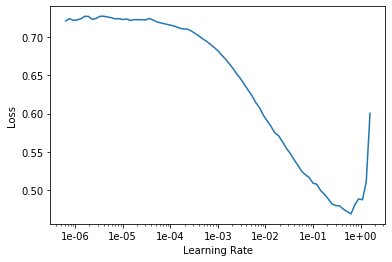

In [0]:
learn_classifier.recorder.plot()

In [0]:
learn_classifier.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.256958,0.204400,0.887113,0.934206,01:40


In [0]:
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.217733,0.178052,0.914341,0.946586,01:56


In [0]:
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.163236,0.143029,0.933029,0.957367,03:23


In [0]:
learn_classifier.unfreeze()
learn_classifier.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.127882,0.142494,0.940808,0.959273,04:13
1,0.134207,0.136850,0.940132,0.957842,04:21


In [0]:
learn_classifier.show_results()

text,target,prediction
"xxbos < abstract > \n < abstracttext label=""objective "" nlmcategory=""objective"">to provide information to genetic counsellors , midwives , nurses , and physicians who are involved in the prenatal care of women dealing with prenatally diagnosed isolated or multiple structural congenital anomalies . < / abstracttext > \n < abstracttext label=""outcomes "" nlmcategory=""results"">to provide better counselling for women and families who are dealing with the diagnosis of a fetal",class3,class3
"xxbos < abstract > \n < abstracttext label=""unlabelled"">the number of young alcoholics increased rapidly around xxmaj tokyo during these several years has resulted in the emergence of xxup aa ( xxmaj alcoholics xxmaj anonymous ) groups consisting mainly of xxunk 30-year - olds . xxmaj it is well known , however , that young alcoholics are difficult to be treated in traditional alcoholic wards where most of the patients",class1,class1
"xxbos xxmaj drugs of the xxmaj benzodiazepine family are among the most frequently prescribed in xxmaj france . xxmaj since anxiety disorders , for which these substances are mostly indicated , affect 10 % of pregnant women , it is very likely that such a treatment could expose many foetuses to xxup bzd during the first three xxmaj months of pregnancy . xxmaj we know that the teratologic effect is",class1;class3,class1;class3
"xxbos < abstract > \n < abstracttext label=""objective "" nlmcategory=""objective"">to evaluate the clinical profiles , image findings and surgical outcome of 155 cases of spinal dysraphism . < / abstracttext > \n < abstracttext label=""methods "" xxunk patients were studied prospectively ( 143 ) or retrospectively ( 12 ) . xxmaj the male to female ratio was xxunk . xxmaj mean age at presentation was 5.7 years .",class3,class3
"xxbos < abstract > \n < abstracttext label=""background "" nlmcategory=""background"">this study aims to evaluate the reduction of cardiac radiation dose and volume with deep inspiration breath hold ( xxup dibh ) technique compared to free breathing ( xxup xxunk ) in patients with left - sided breast cancer . xxmaj the study also aims to evaluate whether the benefits of xxup dibh vary in patients who had whole breast",class1;class2,class1
